In [3]:
import pandas as pd
import numpy as np

In [4]:
train_df = pd.read_csv("3M_VIP_Target_data.csv")

/var/folders/3p/8hc9c44s38j902ytq253kt6m0000gn/T/ipykernel_2385/404477158.py:1: DtypeWarning: Columns (552,637) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("3M_VIP_Target_data.csv")


In [5]:
# 독립변수(X) 후보군 추출 (식별자 및 타겟 변수 제외)
features_list = train_df.select_dtypes(include=[np.number]).drop(columns=['발급회원번호', '기준년월', '이탈_타겟'], errors='ignore').columns

# 전체 데이터(Full) 정제: 무한대 값 처리 및 결측치 0 채움
X_full = train_df[features_list].replace([np.inf, -np.inf], np.nan).fillna(0)
y_full = train_df['이탈_타겟']

# 모든 행의 값이 동일하여 변별력이 없는 컬럼은 사전에 제거
X_full = X_full.loc[:, (X_full != X_full.iloc[0]).any()]

In [6]:
from xgboost import XGBClassifier

# XGBoost 모델 생성 및 전체 데이터 학습 수행
# 모델은 전체 데이터의 복잡한 패턴을 모두 학습함
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_full, y_full)

/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:40:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1764148644238/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. 분석용 균형 샘플링 수행 (타겟 0과 1을 각각 최대 600개씩 추출)
# 이탈자(1)와 유지자(0)의 특성을 균형 있게 반영하기 위함
n_samples = 600
df_0 = train_df[train_df['이탈_타겟'] == 0]
df_1 = train_df[train_df['이탈_타겟'] == 1]

sample_0 = df_0.sample(n=min(len(df_0), n_samples), random_state=42)
sample_1 = df_1.sample(n=min(len(df_1), n_samples), random_state=42)
sample_df = pd.concat([sample_0, sample_1])

# 2. 샘플 데이터 독립변수(X) 정제
# 전체 모델에서 사용된 컬럼과 동일한 구조로 구성
X_sample = sample_df[X_full.columns].replace([np.inf, -np.inf], np.nan).fillna(0)

# 3. VIF(Variance Inflation Factor) 지수 산출 (샘플 데이터 기준)
vif_data = pd.DataFrame()
vif_data["Column"] = X_sample.columns
vif_data["VIF"] = [variance_inflation_factor(X_sample.values, i) for i in range(X_sample.shape[1])]

/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [8]:
import shap

# 4. SHAP Value 계산 (샘플 데이터 기준)
# 이미 학습된 전체 데이터 모델을 활용하여 샘플 데이터의 변수 기여도를 분석함
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# 5. 변수별 평균 절대 SHAP 지수 산출
shap_importance = pd.DataFrame({
    'Column': X_sample.columns,
    'SHAP': np.abs(shap_values).mean(axis=0)
})

# 6. 최종 결과 통합 및 정렬 (컬럼, SHAP, VIF)
final_analysis = pd.merge(shap_importance, vif_data, on='Column')
final_analysis = final_analysis.sort_values(by='SHAP', ascending=False).reset_index(drop=True)

# 7. 최종 결과 출력
print(f"분석 샘플 수: 타겟0({len(sample_0)}건), 타겟1({len(sample_1)}건)")
print("--- [최종 분석 결과: 전체 학습 및 1,200건 균형 샘플 기준] ---")
print(final_analysis)

/usr/local/Caskroom/miniconda/base/envs/myenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


분석 샘플 수: 타겟0(600건), 타겟1(600건)
--- [최종 분석 결과: 전체 학습 및 1,200건 균형 샘플 기준] ---
            Column      SHAP          VIF
0        당월_총_이용금액  9.573217          inf
1     이용금액_일시불_B0M  1.957065          inf
2    직전_3M_평균_이용금액  1.244895          inf
3      이용금액_신용_B0M  0.448775          inf
4          월중평잔_CA  0.423921   334.498872
..             ...       ...          ...
689   이용개월수_신용_R6M  0.000000   169.290551
690      수신거부여부_DM  0.000000    26.307617
691   이용금액_카드론_R6M  0.000000    68.831227
692    소지카드수_유효_신용  0.000000    21.068627
693    이용금액_체크_R6M  0.000000  1208.405883

[694 rows x 3 columns]


In [9]:
file_path = 'VIP_Shap_Vif.csv'
final_analysis.to_csv(file_path, index=False, encoding='utf-8-sig')

# 파일 저장 완료 확인 메시지 출력
print(f"최종 분석 결과가 다음 경로에 저장되었습니다: {file_path}")

최종 분석 결과가 다음 경로에 저장되었습니다: VIP_Shap_Vif.csv


In [10]:
# SHAP 지수 기준 상위 100개 변수 추출
# 분석 결과 데이터프레임(final_analysis)은 이미 SHAP 기준 내림차순 정렬되어 있음
top_100_features = final_analysis.head(100)['Column'].tolist()

# 추출된 변수 개수 확인
print(f"선정된 핵심 변수 개수: {len(top_100_features)}개")

# (선택) 상위 10개 변수 명단 확인
print("--- [상위 10개 핵심 변수] ---")
print(top_100_features[:10])

선정된 핵심 변수 개수: 100개
--- [상위 10개 핵심 변수] ---
['당월_총_이용금액', '이용금액_일시불_B0M', '직전_3M_평균_이용금액', '이용금액_신용_B0M', '월중평잔_CA', '변동률_잔액_B1M', '증감율_이용건수_일시불_전월', 'RP금액_B0M', '잔액_신판최대한도소진율_r3m', '최종연체회차']


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 제외할 컬럼 리스트 정의 (기울기 관련 6개 + 타겟/식별자 3개)
# 기울기 컬럼명은 데이터셋 내의 실제 명칭에 맞게 리스트화함
exclude_cols = [
    '기울기_이용금액_신용', '기울기_이용금액_체크', '기울기_잔액_현금서비스', 
    '기울기_잔액_카드론', '기울기_잔액_신용_일시불', '기울기_잔액_신용_할부',
    '이탈_타겟', '기준년월', '발급회원번호'
]

# 상위 100개 변수 리스트에서 제외 컬럼을 제거하여 최종 학습 변수 선정
final_features = [col for col in top_100_features if col not in exclude_cols]

# 학습 데이터(X)와 타겟 데이터(y) 분리
X = train_df[final_features].replace([np.inf, -np.inf], np.nan).fillna(0)
y = train_df['이탈_타겟']

# 학습용과 테스트용 데이터셋 분리 (8:2 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"최종 사용된 변수 개수: {len(final_features)}개")

최종 사용된 변수 개수: 100개


--- [모델 성능 평가 결과] ---
최종 모델 정확도: 0.9997

[혼동행렬(Confusion Matrix)]
[[11345     1]
 [    2   124]]


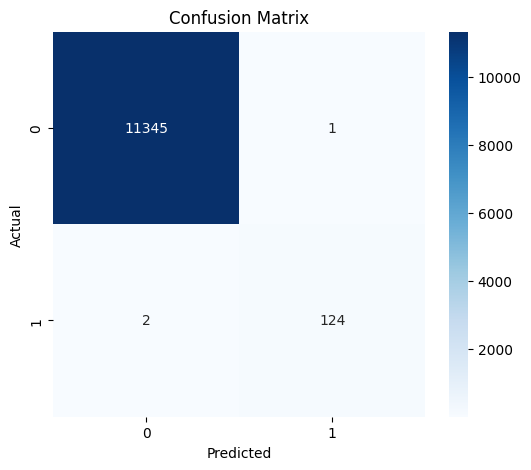


[상세 분류 보고서]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11346
           1       0.99      0.98      0.99       126

    accuracy                           1.00     11472
   macro avg       1.00      0.99      0.99     11472
weighted avg       1.00      1.00      1.00     11472



In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# XGBoost 모델 객체 생성 및 학습 수행
model_final = XGBClassifier(random_state=42, eval_metric='logloss')
model_final.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_pred = model_final.predict(X_test)

# 정확도(Accuracy) 산출
accuracy = accuracy_score(y_test, y_pred)

# 혼동행렬(Confusion Matrix) 산출
cm = confusion_matrix(y_test, y_pred)

# 결과 출력
print(f"--- [모델 성능 평가 결과] ---")
print(f"최종 모델 정확도: {accuracy:.4f}")
print("\n[혼동행렬(Confusion Matrix)]")
print(cm)

# 혼동행렬 시각화
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 상세 지표(Precision, Recall, F1-score) 출력
print("\n[상세 분류 보고서]")
print(classification_report(y_test, y_pred))

In [13]:
import pandas as pd
import numpy as np

# 1. 범주형(Object) 컬럼 추출 및 데이터 타입 변환
# 문자열 데이터를 XGBoost의 category 학습 기능을 위해 변환 수행
obj_cols = train_df.select_dtypes(include=['object']).columns
for col in obj_cols:
    train_df[col] = train_df[col].astype('category')

# 2. 시간순 데이터 분할 (12월을 시험지로 설정)
last_month = train_df['기준년월'].max()
train_df_time = train_df[train_df['기준년월'] < last_month]
test_df_time = train_df[train_df['기준년월'] == last_month]

# 3. 누수 방지를 위한 변수 제외 리스트 적용
# 당월 실적(_B0M), 정답 생성 변수, 식별자 등 제거
drop_cols = [col for col in train_df.columns if '_B0M' in col or '당월' in col] + \
            ['이용금액_신용_R3M', '이용금액_체크_R3M', '직전_3M_평균_이용금액', '발급회원번호', '기준년월', '이탈_타겟']

X_train = train_df_time.drop(columns=drop_cols, errors='ignore')
y_train = train_df_time['이탈_타겟']

X_test = test_df_time.drop(columns=drop_cols, errors='ignore')
y_test = test_df_time['이탈_타겟']

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 4. XGBoost 모델 설정 및 학습 수행
# enable_categorical=True 옵션을 활성화하여 범주형 변수를 자동으로 처리함
model_final = XGBClassifier(
    n_estimators=100, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42,
    enable_categorical=True, # 범주형 데이터 학습 활성화
    eval_metric='logloss'
)
model_final.fit(X_train, y_train)

# 5. 결과 확인 및 성능 지표 산출
y_pred = model_final.predict(X_test)

print(f"--- {last_month} 데이터 기준 예측 결과 (범주형 변수 포함) ---")
print(classification_report(y_test, y_pred))

# 혼동행렬 출력
print("\n[혼동행렬(Confusion Matrix)]")
print(confusion_matrix(y_test, y_pred))

--- 201812 데이터 기준 예측 결과 (범주형 변수 포함) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9453
           1       0.83      0.52      0.64        56

    accuracy                           1.00      9509
   macro avg       0.91      0.76      0.82      9509
weighted avg       1.00      1.00      1.00      9509


[혼동행렬(Confusion Matrix)]
[[9447    6]
 [  27   29]]


In [15]:
######### 오버샘플링 과정 

In [16]:
from sklearn.preprocessing import LabelEncoder

# 1. 범주형 변수를 수치형으로 인코딩
# SMOTE 알고리즘 적용을 위해 모든 범주형(Object/Category) 변수를 수치로 변환함
le = LabelEncoder()
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train.select_dtypes(include=['category', 'object']).columns:
    # 학습 데이터와 테스트 데이터에 동일한 인코딩 기준 적용
    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
    X_test_encoded[col] = le.transform(X_test[col].astype(str))

# 결측치를 0으로 다시 한번 확인하여 데이터 무결성 확보
X_train_encoded = X_train_encoded.fillna(0)
X_test_encoded = X_test_encoded.fillna(0)

In [17]:
from imblearn.over_sampling import SMOTE

# 2. SMOTE 알고리즘을 활용한 오버샘플링 수행
# 소수 클래스(이탈: 1)를 다수 클래스(유지: 0)의 개수와 동일하게 증폭함
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train_encoded, y_train)

# 샘플링 결과 확인
print("--- [오버샘플링 적용 전/후 데이터 구성] ---")
print(f"적용 전 이탈자 수: {sum(y_train == 1)}건")
print(f"적용 후 이탈자 수: {sum(y_train_over == 1)}건")

--- [오버샘플링 적용 전/후 데이터 구성] ---
적용 전 이탈자 수: 574건
적용 후 이탈자 수: 47274건


In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 3. 오버샘플링된 데이터를 활용한 XGBoost 모델 학습
# 데이터 양이 증가하였으므로 하이퍼파라미터는 기존 설정을 유지하여 비교함
model_smote = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

model_smote.fit(X_train_over, y_train_over)

# 4. 테스트 데이터(12월)에 대한 예측 및 성능 평가
y_pred_smote = model_smote.predict(X_test_encoded)

print(f"--- SMOTE 오버샘플링 적용 후 예측 결과 ---")
print(classification_report(y_test, y_pred_smote))

print("\n[혼동행렬(Confusion Matrix)]")
print(confusion_matrix(y_test, y_pred_smote))

--- SMOTE 오버샘플링 적용 후 예측 결과 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9453
           1       0.67      0.64      0.65        56

    accuracy                           1.00      9509
   macro avg       0.83      0.82      0.83      9509
weighted avg       1.00      1.00      1.00      9509


[혼동행렬(Confusion Matrix)]
[[9435   18]
 [  20   36]]


In [19]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. 데이터 타입 재확인
# LightGBM은 pandas의 category 타입을 자동으로 인식하여 최적의 분기점을 찾음
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# 2. 불균형 대응을 위한 가중치 계산
# 유지(0) 대비 이탈(1)의 비율을 계산하여 모델에 전달
scale_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [20]:
###### LightGBM 모델 

In [21]:
# 3. LightGBM 모델 객체 생성
# categorical_feature='auto': category 타입 컬럼을 자동으로 감지하여 처리함
model_lgbm = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    scale_pos_weight=scale_weight, # Recall 향상을 위한 가중치 적용
    importance_type='gain',        # 변수 중요도를 SHAP과 유사한 gain 방식으로 산출
    verbose=-1                     # 불필요한 로그 출력 방지
)

# 4. 모델 학습 수행
model_lgbm.fit(X_train, y_train)

# 5. 테스트 데이터(12월) 예측 및 결과 출력
y_pred_lgbm = model_lgbm.predict(X_test)

print(f"--- [LightGBM] {last_month} 데이터 기준 예측 결과 ---")
print(f"정확도(Accuracy): {accuracy_score(y_test, y_pred_lgbm):.4f}")
print("\n[상세 분류 보고서]")
print(classification_report(y_test, y_pred_lgbm))

print("\n[혼동행렬(Confusion Matrix)]")
print(confusion_matrix(y_test, y_pred_lgbm))

--- [LightGBM] 201812 데이터 기준 예측 결과 ---
정확도(Accuracy): 0.9950

[상세 분류 보고서]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9453
           1       0.56      0.71      0.62        56

    accuracy                           0.99      9509
   macro avg       0.78      0.86      0.81      9509
weighted avg       1.00      0.99      1.00      9509


[혼동행렬(Confusion Matrix)]
[[9421   32]
 [  16   40]]


In [22]:
# 1. 범주형 변수 수치 인코딩 (SMOTE 적용을 위한 필수 단계)
# LightGBM 학습 전, 모든 문자열/범주형 데이터를 정수형으로 변환함
le = LabelEncoder()
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# 범주형 컬럼 리스트 추출
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns

for col in cat_cols:
    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
    X_test_encoded[col] = le.transform(X_test[col].astype(str))

# 2. SMOTE를 이용한 오버샘플링 수행
# 이탈자(1) 데이터를 유지자(0) 데이터의 개수와 동일하게 생성함
smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train_encoded.fillna(0), y_train)

print(f"오버샘플링 후 학습 데이터 구성: 유지({sum(y_train_over==0)}건), 이탈({sum(y_train_over==1)}건)")

오버샘플링 후 학습 데이터 구성: 유지(47274건), 이탈(47274건)


In [23]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

# 3. LightGBM 모델 설정 및 학습
# SMOTE로 데이터 균형을 맞췄으므로 scale_pos_weight는 별도로 설정하지 않음
model_lgbm_smote = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    importance_type='gain',
    verbose=-1
)

# 인코딩된 범주형 변수 위치를 모델에게 알려줌 (학습 효율 증대)
model_lgbm_smote.fit(
    X_train_over, 
    y_train_over, 
    categorical_feature=list(cat_cols)
)

# 4. 12월 테스트 데이터 기반 성능 평가
y_pred_lgbm_smote = model_lgbm_smote.predict(X_test_encoded.fillna(0))

print(f"--- [LightGBM + SMOTE] {last_month} 데이터 기준 예측 결과 ---")
print(classification_report(y_test, y_pred_lgbm_smote))

print("\n[혼동행렬(Confusion Matrix)]")
print(confusion_matrix(y_test, y_pred_lgbm_smote))

--- [LightGBM + SMOTE] 201812 데이터 기준 예측 결과 ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9453
           1       0.71      0.62      0.67        56

    accuracy                           1.00      9509
   macro avg       0.86      0.81      0.83      9509
weighted avg       1.00      1.00      1.00      9509


[혼동행렬(Confusion Matrix)]
[[9439   14]
 [  21   35]]
